# Creating a Monetization Model for a Game App

In this project, we will analyze data from user activity on the "Space Brothers" gaming app. Our goal is to provide recommendations based on our analysis which will help the app developers as they are creating a monetization model for the app. We will also explore in what ways the various target values are affected by the way users play the game (the events they encounter and the objects they build). Finally, we will also test the statistical significance of differences between users who complete the game based on finishing the in game project and the users who complete the game based on defeating the boss.

Let's get started.

## Import Libraries & Data

First, let's import the needed libraries.

In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
import numpy as np
from scipy import stats as st

Now, let's import the data and take a glance at it.

In [5]:
try:
    events = pd.read_csv('events_us.csv')
except:
    events = pd.read_csv('/datasets/events_us.csv')
events.head()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


Above, we have data representing every event encountered including date/time and user id as well as the building type and project type for each relevent event.

In [6]:
try:
    costs = pd.read_csv('ad_costs_us.csv')
except:
    costs = pd.read_csv('/datasets/ad_costs_us.csv')
costs.head()

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


Above, we have the cost for advertising the game app per source and date for all seven days.

In [7]:
try:
    source = pd.read_csv('user_source_us.csv')
except:
    source = pd.read_csv('/datasets/user_source_us.csv')
source.head()

,user_id,event_date,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06,google_play_ads
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05,youtube_channel_network
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05,facebook_ads


The final dataset shows the event date and source for every user. The date and source are factors that may impact the target event (the "building" event in which users will encounter in game ads which will generate income for the app developers).

## Data Preprocessing

Here, we will check the data for any issues, convert datatypes, fill missing values, merge our datasets together and add other helpful columns.

### Check for Duplicates

Let's check for duplicates on all three datasets using .duplicated().

In [8]:
print('Number of duplicates in "events" dataset:', events.duplicated().sum())

Number of duplicates in "events" dataset: 1


In [9]:
print('Number of duplicates in "costs" dataset:', costs.duplicated().sum())

Number of duplicates in "costs" dataset: 0


In [10]:
print('Number of duplicates in "source" dataset:', source.duplicated().sum())

Number of duplicates in "source" dataset: 0


Let's look at the duplicate row in the "events" dataset.

In [11]:
events.loc[events.duplicated()]

,event_datetime,event,building_type,user_id,project_type
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


Could it be that this user built two research centers in one second? It's possible, but we cannot confirm this with the knowledge we currently have. We will delete this duplicate.

In [12]:
events = events.drop_duplicates()

### Check Columns

Let's replace any potential spaces in the column names with "_". This will avoid any confusion when referencing the columns by name. This will be done using str.replace().

In [13]:
events.columns = events.columns.str.replace(" ", "_")
costs.columns = costs.columns.str.replace(" ", "_")
source.columns = source.columns.str.replace(" ", "_")

Now, let's take a look at each data set using .info() to see the results. This will also show us missing values and datatypes for all columns.

In [14]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135639 non-null  object
 1   event           135639 non-null  object
 2   building_type   127956 non-null  object
 3   user_id         135639 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 6.2+ MB


In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


In [16]:
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     13576 non-null  object
 1   event_date  13576 non-null  object
 2   source      13576 non-null  object
dtypes: object(3)
memory usage: 318.3+ KB


We can see here that none of the column names have gained "_" to represent a hidden space. We also see that the date columns are in the "object" datatype. Additionally, we see missing values in two of the columns in the "events" dataset. Let's tackle the date columns first.

### Change data types

Let's adjust the change the date columns to a datetime format that Python can recognize.

In [17]:
#Change datqatype datetime
events['event_datetime'] = pd.to_datetime(events['event_datetime'], format='%Y-%m-%d %H:%M:%S')
source['event_date'] = pd.to_datetime(source['event_date'], format='%Y-%m-%d')

Now, all columns have suitable datatypes.

### Missing Values

There is a good chance the missing values in the "events" dataset are related to the "events" column. Let's take a look at the counts per unique event using .groupby().

In [18]:
events.groupby('event').count()

,event_datetime,building_type,user_id,project_type
event,,,,
building,127956,127956,127956,0
finished_stage_1,5817,0,5817,0
project,1866,0,1866,1866


We can see here that the number of "building" events matches the number of building_type values and the number of "project" events matches the number of project_type values. The building_type and project_type columns are redundant. Let's collapse the values from both into a new column object_type and delete the old column.

In [19]:
events.building_type.fillna(events.project_type, inplace=True)
events = events.rename(columns={'building_type': 'object_type'})
del events['project_type']
events.head()

,event_datetime,event,object_type,user_id
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d


In [20]:
events.groupby('event').count()

,event_datetime,object_type,user_id
event,,,
building,127956,127956,127956
finished_stage_1,5817,0,5817
project,1866,1866,1866


Now the project_type values have been moved into the object_type column.

### Merge Source Data with Events Table

Next we will merge the "source" table with the events "table" so that all the data is included in one table. First, let's take a look at the unique user_ids along with the row counts to help us avoid duplicates.

In [21]:
print('Rows in "source": ', len(source))
print('Unique user_ids in "source": ', source['user_id'].nunique())
print('Rows in "events": ', len(events))
print('Unique user_ids in "events": ', events['user_id'].nunique())

Rows in "source":  13576
Unique user_ids in "source":  13576
Rows in "events":  135639
Unique user_ids in "events":  13576


Both datasets have the same number of user_ids. Now, let's merge the tables using .merge() and rename the event_date column in "source" to ad_date. We will then check the number of rows again to make sure it is unchainged.

In [22]:
events = events.merge(source, on='user_id')
events = events.rename(columns={'event_date': 'ad_date'})
print('Rows in "events": ', len(events))
print('Unique user_ids in "events": ', events['user_id'].nunique())
events.head()

Rows in "events":  135639
Unique user_ids in "events":  13576


,event_datetime,event,object_type,user_id,ad_date,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network


Now all the user data from "source" is included in our "events" dataset. And the number of rows is the same as before, so we know that we created no duplicates.

### Add event_date and days_since_ad_date Column

Let's also add columns that represent the event date (event_date), number of days between event_date and ad_date. This column will be helpful in comparing the number of days it took users to complete the first stage of the game.

In [23]:
events['event_date'] = pd.DatetimeIndex(events['event_datetime']).date
events['event_date'] = pd.to_datetime(events['event_date'], format='%Y-%m-%d')
events['days_since_ad_date'] = events['event_date'] - events['ad_date']
events['days_since_ad_date'] = events['days_since_ad_date'].astype('timedelta64[D]').astype(int)
events.head()

,event_datetime,event,object_type,user_id,ad_date,source,event_date,days_since_ad_date
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-04,0
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-05,1
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-05,1
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-05,1
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-06,2


### Creating Classification Column for "Project" Completion vs. "Boss" Completion v. "Incomplete"

We will also create a classification column for how users completed the first stage of the game. To do this, we will first add a binary "1" or "0" column to our events table. To start, we will create a dictionary of users who have completed the first stage by slicing the appropriate users and making a column storing "1" as the event count, naming it stage_1_completed.

In [24]:
users_completed_stage_1 = events.loc[events.loc[:,'event'] == 'finished_stage_1']
users_completed_stage_1 = users_completed_stage_1.groupby('user_id').agg({'event' : 'count'})
users_completed_stage_1 = users_completed_stage_1.rename(columns={'event': 'stage_1_completed'})
users_completed_stage_1.head()

,stage_1_completed
user_id,
001d39dc-366c-4021-9604-6a3b9ff01e25,1
003ee7e8-6356-4286-a715-62f22a18d2a1,1
004074f8-251a-4776-922c-8348dca1a2f6,1
00464e5e-28ed-4be6-bf44-517ef7b3937b,1
0056c007-c082-43cc-bdef-afc49bca4cb9,1


Now, let's join this dictionary to our "events" table, filling the missing values in the stage_1_completed with "0" and converting the datatype to integer.

In [25]:
events = events.join(users_completed_stage_1, on='user_id')
events['stage_1_completed'] = events['stage_1_completed'].fillna(0)
events['stage_1_completed'] = events['stage_1_completed'].astype(int)
events.head()

,event_datetime,event,object_type,user_id,ad_date,source,event_date,days_since_ad_date,stage_1_completed
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-04,0,0
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-05,1,0
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-05,1,0
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-05,1,0
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-06,2,0


We now have a column showing a binary category for whether users have completed stage 1. We know that users can complete the first stage of the game in one of two ways, either through building the orbital satellite-assembly (characterized by encountering the "project" event) or by defeating the boss (all users who complete the first stage without encountering the "project" event. Let's create a column called p_or_b to identify what method each user completed the first stage. First, we will make a dictionary of user_ids who completed the first stage via the project route. We will make a slice for all records for users who have completed stage 1. Then, we will make a slice for which completed users got their via the project route and clean up the table into a dictionary using .copy() to select the desired columns and .rename() to rename the columns, setting the user_id as the index.

In [26]:
completed_slice = events.loc[events.loc[:,'stage_1_completed'] == 1]
#Make a slice of all rows containing the "project" event
project = completed_slice.loc[completed_slice.loc[:,'event'] == 'project']
#Make copy and reduce to user_id and "event" columns
project = project[['user_id', 'event']].copy()
#Rename column to p_or_b'
project = project.rename(columns={'event': 'p_or_b'})
#Set user_id as index
project = project.set_index(['user_id'])
project.head()

,p_or_b
user_id,
c07b1c10-f477-44dc-81dc-ec82254b1347,project
65a92713-5969-48b1-8945-bfefa5063887,project
fa352362-d258-472c-b295-2796ccc39fa3,project
7b3b6554-7949-4065-9808-d6c79bdc2f58,project
b374304d-2f74-4cc1-a4e2-500da44a06c7,project


Now, we can join this list to our completed_slice table and fill the missing values with "boss".

In [27]:
completed_slice = completed_slice.join(project, on='user_id')
completed_slice['p_or_b'] = completed_slice['p_or_b'].fillna('boss')
completed_slice.head()

,event_datetime,event,object_type,user_id,ad_date,source,event_date,days_since_ad_date,stage_1_completed,p_or_b
7,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,2020-05-04,facebook_ads,2020-05-04,0,1,project
8,2020-05-06 23:49:25,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,2020-05-04,facebook_ads,2020-05-06,2,1,project
9,2020-05-07 03:56:30,building,spaceport,c07b1c10-f477-44dc-81dc-ec82254b1347,2020-05-04,facebook_ads,2020-05-07,3,1,project
10,2020-05-07 07:58:20,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,2020-05-04,facebook_ads,2020-05-07,3,1,project
11,2020-05-07 08:30:13,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,2020-05-04,facebook_ads,2020-05-07,3,1,project


Now, let's condense these down into another dictionary of users which identifies "project" or "boss".

In [28]:
p_or_b_users = completed_slice.groupby('user_id').agg({'p_or_b' : 'first'})
p_or_b_users.head()

,p_or_b
user_id,
001d39dc-366c-4021-9604-6a3b9ff01e25,boss
003ee7e8-6356-4286-a715-62f22a18d2a1,boss
004074f8-251a-4776-922c-8348dca1a2f6,boss
00464e5e-28ed-4be6-bf44-517ef7b3937b,boss
0056c007-c082-43cc-bdef-afc49bca4cb9,boss


Finally, we can join this dictionary to our original "events" table.

In [29]:
events = events.join(p_or_b_users, on='user_id')
events.head()

,event_datetime,event,object_type,user_id,ad_date,source,event_date,days_since_ad_date,stage_1_completed,p_or_b
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-04,0,0,NaN
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-05,1,0,NaN
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-05,1,0,NaN
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-05,1,0,NaN
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-06,2,0,NaN


No we have a column identifying each user as "project", "boss" or NaN if they did not complete at all. Let's replace all NaN values with "incomplete".

In [30]:
events['p_or_b'] = events['p_or_b'].fillna('incomplete')
events.head()

,event_datetime,event,object_type,user_id,ad_date,source,event_date,days_since_ad_date,stage_1_completed,p_or_b
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-04,0,0,incomplete
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-05,1,0,incomplete
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-05,1,0,incomplete
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-05,1,0,incomplete
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-06,2,0,incomplete


Now we have an "events" table which includes the data from "source". Between our modified "events" dataset and our "costs" dataset, we have a lot to explore. The "costs" dataset provides the advertising expenses per source. This will help us to explore the amount of money that is being spent on our users. We also have several interesting groups to compare and investigate proportions for in our new p_or_b column. We can investigate the relationship between various events and object types relates to users who completed stage one vs those who haven't as well as "p" vs "b" users. We can compare how many days it took the separate groups to complete stage 1. Our main interest is the four source categories. It will be valuable to get an idea of cost per user and to investigate whether there is a difference in performance between users of each source. This information will help us make recommendations on which sources provide a better return on investment. 

## Eploratory Data Analysis

Now, we will begin the EDA. We will get an overview of ad source costs and events. We will calculate proportions of users who land in target groups. We will plot histograms for "building" events encountered as well as users per day and events per day.

### Costs

Let create a pivot table showing the averaged cost per source.

In [31]:
average_costs_per_source = costs.pivot_table(index='source', values='cost', aggfunc='mean')
average_costs_per_source

,cost
source,
facebook_ads,305.843520
google_play_ads,319.015921
instagram_new_adverts,308.777384
youtube_channel_network,152.588458


There are four ad sources. The all fall at an average cost per day of $300 except for youtube_channel_network which is about half the cost of other ads. Let's make a pivot table to show the cost per day for each source.

In [32]:
costs.pivot_table(index='day', columns='source', values='cost', aggfunc='mean')

source,facebook_ads,google_play_ads,instagram_new_adverts,youtube_channel_network
day,,,,
2020-05-03,935.882786,969.139394,943.204717,454.224943
2020-05-04,548.354480,554.651494,502.925451,259.073224
2020-05-05,260.185754,308.232990,313.970984,147.041741
2020-05-06,177.982200,180.917099,173.071145,88.506074
2020-05-07,111.766796,114.429338,109.915254,55.740645
2020-05-08,68.009276,62.961630,71.578739,40.217907
2020-05-09,38.723350,42.779505,46.775400,23.314669


The ads ran for seven days, Sunday through Saturday. The cost decrease by about half each day across all sources. Again, youtube_channel_network stand out here in that the cost reduction from the first to second day decreases by a much smaller rate than the others. Let's look at a histogram showing the distribution of costs across all days.

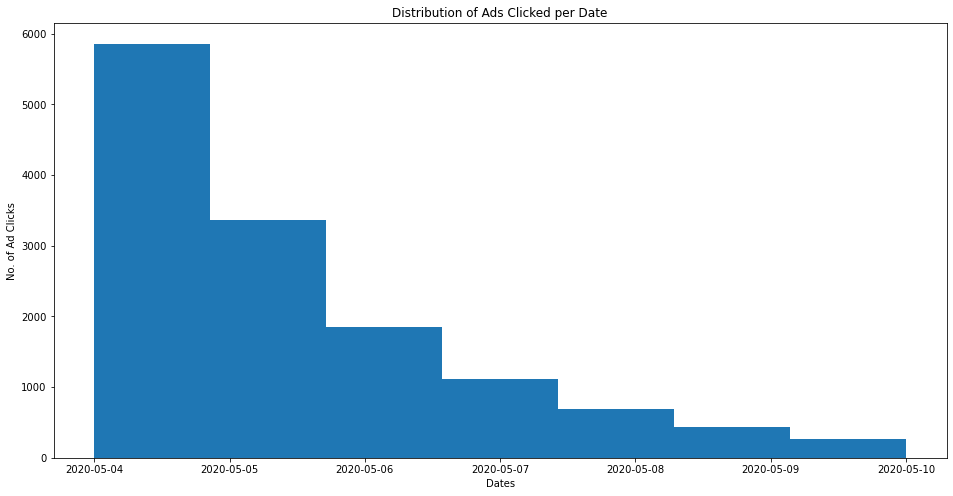

In [33]:
plt.figure(figsize=(16, 8))
plt.hist(data=source, x='event_date', bins=(7))
plt.title('Distribution of Ads Clicked per Date')
plt.ylabel('No. of Ad Clicks')
plt.xlabel('Dates')
plt.show()

Seeing as the costs decrease at a consistent rate across all sources, it seems that the game developers are paying per click, and users' clicks decrease by half per day. We cannot tell from the data we have why less users are clicking per day. It could be that the initial exposure reaches the biggest audience. Let's investigate costs per user next. To calculate this, we will simply total all costs and divide by the length of rows in our "source" dataset.

In [34]:
average_cost_per_user = costs['cost'].sum() / len(source)
print('The average cost per user is:', average_cost_per_user)

The average cost per user is: 0.5600749106355349


Now, let's calculate the average cost per user per source. To do this, we will first calculate total costs per source.

In [35]:
costs_per_source = costs.pivot_table(index='source', values='cost', aggfunc='sum')
costs_per_source

,cost
source,
facebook_ads,2140.904643
google_play_ads,2233.111449
instagram_new_adverts,2161.441691
youtube_channel_network,1068.119204


Now, let's count the unique users per source.

In [36]:
users_per_source = events.groupby('source').agg({'user_id': 'nunique'})
users_per_source

,user_id
source,
facebook_ads,2726
google_play_ads,4817
instagram_new_adverts,3347
youtube_channel_network,2686


Now, let's add it to our costs_per_source table and calculate  the cost per user.

In [37]:
costs_per_source['users'] = users_per_source['user_id']
costs_per_source['cost_per_user'] = costs_per_source['cost'] / costs_per_source['users']
costs_per_source

,cost,users,cost_per_user
source,,,
facebook_ads,2140.904643,2726,0.785365
google_play_ads,2233.111449,4817,0.463590
instagram_new_adverts,2161.441691,3347,0.645785
youtube_channel_network,1068.119204,2686,0.397662


Let's show the results in a bar chart. We will include a red line showing the overall average cost per user.

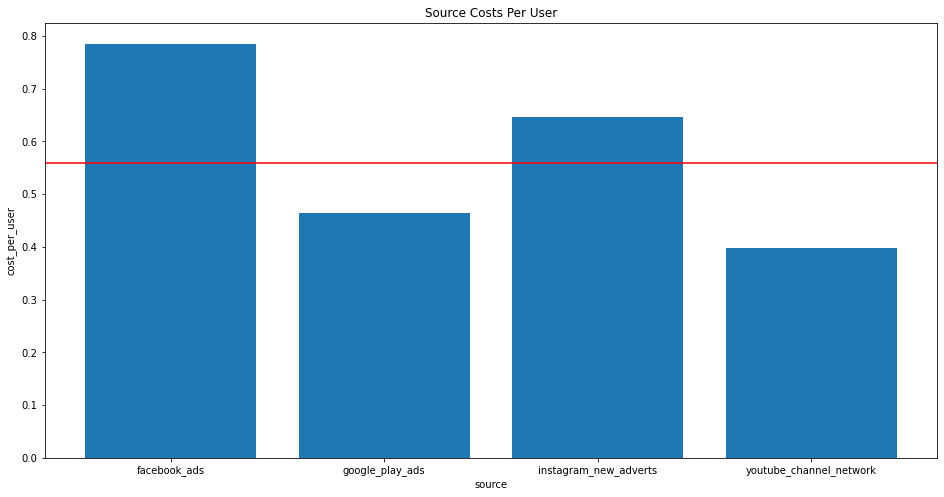

In [38]:
plt.figure(figsize=(16, 8))
plt.bar(['facebook_ads', 'google_play_ads', 'instagram_new_adverts', 'youtube_channel_network'],\
        costs_per_source['cost_per_user'])
plt.title('Source Costs Per User')
plt.ylabel('cost_per_user')
plt.xlabel('source')
plt.axhline(y=average_cost_per_user, color='r', linestyle='-')
plt.show()

This is very helpful information. It shows us that facebook_ads are almost twice as much as youtube_channel_network ads. (That only seems reasonable if facebook_ads performs twice as good as youtube_channel_network.) Additionally, it shows us which sources' cost_per_user are above and below average. Let's move on to the events dataset.

### Quick "events" Overview

Let's get an idea of event quantity, unique user quantity, date range, and the average number of events per day.

In [39]:
total_events = events.shape[0]
print('Number of events:', total_events) 
total_users = len(events['user_id'].unique())
print('Number of users:', total_users)
print('Date range: ', events["event_date"].min(), ' through ', events["event_date"].max()) 
total_days = len(events['event_date'].unique())
print('Total days: ', total_days)
events_per_user_and_day = total_events / total_users / total_days  
print('Number of events per user per day:', events_per_user_and_day)

Number of events: 135639
Number of users: 13576
Date range:  2020-05-04 00:00:00  through  2020-06-05 00:00:00
Total days:  33
Number of events per user per day: 0.30276021856752555


The number of users in the events dataset matches the number of users in the source dataset. The date range is a little over a months’ worth of dates. Events averaged across users and dates is 0.3. This means most users did not encounter very many events. We will investigate the distribution of events soon.

### Proportions Based on Stage 1 Completion and p_or_b Status

Before that, let's view the numbers of users based on their p_or_b status using a pivot table. We will display the results in a pie chart.

In [40]:
users_per_p_or_b_status = events.pivot_table(index='p_or_b', values='user_id', aggfunc='nunique')
users_per_p_or_b_status

,user_id
p_or_b,
boss,3951
incomplete,7759
project,1866


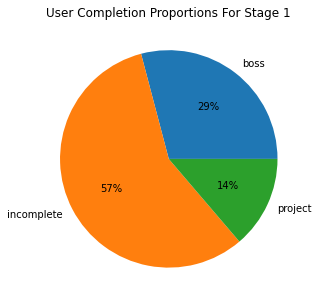

In [41]:
plt.figure(figsize=(10, 5))
plt.pie(users_per_p_or_b_status['user_id'], labels=users_per_p_or_b_status.index, autopct='%.0f%%')
plt.title('User Completion Proportions For Stage 1')
plt.show()

Most users do not complete stage 1 of the game. Of those who do complete stage 1, "boss" users are twice as popular as "project" users.

Now let's make a pivot table  of the same information, but displaying it per source.

In [42]:
users_per_p_or_b_status_per_source = events.pivot_table(index='p_or_b', columns= 'source', values='user_id',\
                                                        aggfunc='nunique')
users_per_p_or_b_status_per_source

source,facebook_ads,google_play_ads,instagram_new_adverts,youtube_channel_network
p_or_b,,,,
boss,759,1422,990,780
incomplete,1576,2775,1881,1527
project,391,620,476,379


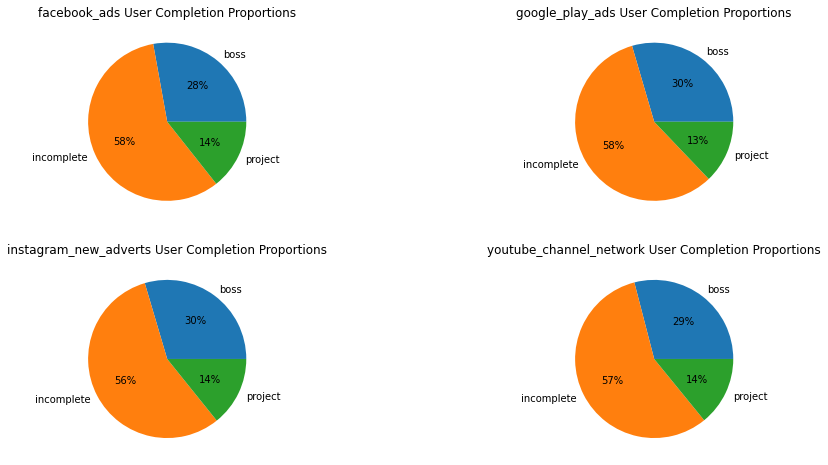

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

axs[0, 0].pie(users_per_p_or_b_status_per_source['facebook_ads'], labels=users_per_p_or_b_status.index, autopct='%.0f%%')
axs[0, 0].set_title('facebook_ads User Completion Proportions')

axs[0, 1].pie(users_per_p_or_b_status_per_source['google_play_ads'], labels=users_per_p_or_b_status.index, autopct='%.0f%%')
axs[0, 1].set_title('google_play_ads User Completion Proportions')

axs[1, 0].pie(users_per_p_or_b_status_per_source['instagram_new_adverts'], labels=users_per_p_or_b_status.index, autopct='%.0f%%')
axs[1, 0].set_title('instagram_new_adverts User Completion Proportions')

axs[1, 1].pie(users_per_p_or_b_status_per_source['youtube_channel_network'], labels=users_per_p_or_b_status.index, autopct='%.0f%%')
axs[1, 1].set_title('youtube_channel_network User Completion Proportions')

plt.show()

Here we see that facebook_ads and google_play_ads are the best performers for users who complete stage 1. instagram_new_adverts happens to be the worst. Overall, the results are very similar. We have not established whether "project" users or "boss" users are more preferable.

Let's take a closer look at the proportions of stage 1 complete users for each source. We will take every user's first row, and average out the stage_1_completed column per source. We will show the results in a bar chart with a line representing the overall proportion.

In [44]:
stage_1_completed_proportions = events.groupby('user_id').first().groupby('source').agg({'stage_1_completed' : 'mean'})
stage_1_completed_proportions

,stage_1_completed
source,
facebook_ads,0.421864
google_play_ads,0.423915
instagram_new_adverts,0.438004
youtube_channel_network,0.431497


In [45]:
users_complete_game_proportion = len(users_completed_stage_1) / events['user_id'].nunique()
print('Proportion of users who completed stage 1: {:.0%}'.format(users_complete_game_proportion))

Proportion of users who completed stage 1: 43%


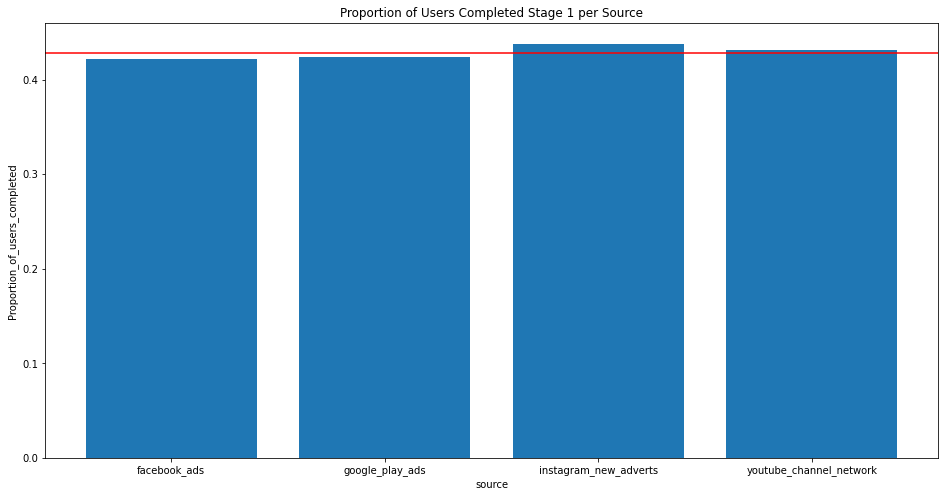

In [46]:
plt.figure(figsize=(16, 8))
plt.bar(stage_1_completed_proportions.index, stage_1_completed_proportions['stage_1_completed'])
plt.title('Proportion of Users Completed Stage 1 per Source')
plt.ylabel('Proportion_of_users_completed')
plt.xlabel('source')
plt.axhline(y=users_complete_game_proportion, color='r', linestyle='-')
plt.show()

Proportions are very similar across the board. However, we can see that some sources performed above average, and some did not.

### Events and object_type

Let's take a look at the number of events per event type. We will use a pivot table and shows the results with p_or_b classifications for columns.

In [47]:
events.pivot_table(index='event', columns='p_or_b', values='event_datetime', aggfunc='count')

p_or_b,boss,incomplete,project
event,,,
building,37185.0,67170.0,23601.0
finished_stage_1,3951.0,NaN,1866.0
project,NaN,NaN,1866.0


Most events are "building" events. Users must encounter ads when building new objects. As such "building" events would make for a good target variable. However, the data is cut off after users complete stage 1 of the game. This means that there is a good likelihood that the users who have completed stage 1 will encounter further events. It seems like finished_stage_1 will be the best target variable, as these users are likely to have encountered many "building" events and are likely to encounter more in the future. We can also see here that "project" users tend to encounter the "building" event more than "boss" users. As such, it seems like "project" users are preferable.

Let's take a look at the diastribution of object_types.

In [48]:
events.pivot_table(index='object_type', columns='p_or_b', values='event_datetime', aggfunc='count')

p_or_b,boss,incomplete,project
object_type,,,
assembly_shop,16298.0,29080.0,9116.0
research_center,3755.0,6685.0,3697.0
satellite_orbital_assembly,NaN,NaN,1866.0
spaceport,17132.0,31405.0,10788.0


As noticed above, the satellite_orbital_assembly coincides with the project event. The remaining object types have varying quantities, but they are all desirable as we know the users will encounter adds when selecting one of these building types. Let's move on to take a closer look at the "building" events.

### "Building" Events Encountered

The users will encounter ads when they encounter the "building" event. As such, this is a target variable. Let's take a look to see how many "building" events users encountered on average. To do this, we will first make a slice of all building events and create a table based on that slice which shows the total events per user along with the p_or_b classification.

In [49]:
building_events_all = events.loc[events.loc[:,'event'] == 'building']
buildings_per_user = building_events_all.groupby('user_id').agg({'event_datetime' : 'count', 'p_or_b' : 'first',\
                                                                 'source' : 'first'})

buildings_per_user.head()

,event_datetime,p_or_b,source
user_id,,,
0001f83c-c6ac-4621-b7f0-8a28b283ac30,13,incomplete,facebook_ads
00151b4f-ba38-44a8-a650-d7cf130a0105,9,incomplete,google_play_ads
001aaea6-3d14-43f1-8ca8-7f48820f17aa,4,incomplete,youtube_channel_network
001d39dc-366c-4021-9604-6a3b9ff01e25,8,boss,instagram_new_adverts
002f508f-67b6-479f-814b-b05f00d4e995,12,incomplete,facebook_ads


Now let's take a look at the distribution in a histogram.

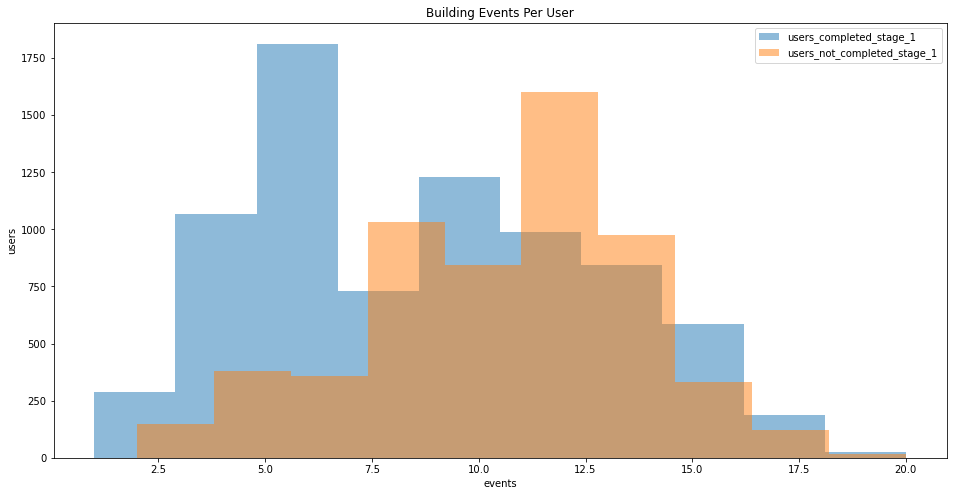

In [50]:
plt.figure(figsize=(16, 8))
plt.hist(data=buildings_per_user.loc[buildings_per_user.loc[:,'p_or_b'] == 'incomplete'], x='event_datetime', bins=(10), alpha=0.5)
plt.hist(data=buildings_per_user.loc[buildings_per_user.loc[:,'p_or_b'] != 'incomplete'], x='event_datetime', bins=(10), alpha=0.5)
plt.title('Building Events Per User')
plt.ylabel('users')
plt.xlabel('events')
plt.legend(labels=['users_completed_stage_1', 'users_not_completed_stage_1'])
plt.show()

We can see clearly here that users who complete stage 1 tend to complete many more building events than users who did not complete stage 1. Many of the "incomplete" users peak at 6 buildings and drop off immediately. Completed users peak around (12) events.

Before we continue, let's run a boxplot to see the where most of the values lie and whether or not their are outliers. We will base it on the following buildings_per_user table.

Events Per User Boxplot


<Figure size 1152x576 with 0 Axes>

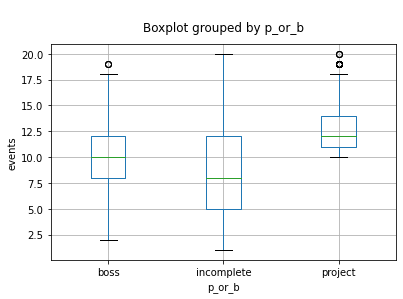

In [51]:
print('Events Per User Boxplot')
plt.figure(figsize=(16, 8))
buildings_per_user.boxplot(column='event_datetime', by='p_or_b')
plt.title(' ', y=1.1)
plt.ylabel('events')
plt.show()

Most users fall within 5 to 13 "building" events. "incomplete" has a wider range because it include many more users. There are a couple outliers for the "project" and "boss" groups. Let's remove those so that we can compare them . Now, let's make two more slices of data from the "building" events of those who completed and did not complete the first stage of the game. To do this, we will create a dictionary of all the outliers.

In [52]:
outliers = buildings_per_user.loc[(buildings_per_user.loc[:,'p_or_b'] != 'incomplete') &\
                                  (buildings_per_user.loc[:,'event_datetime'] > 18)]
outliers.head()

,event_datetime,p_or_b,source
user_id,,,
296c14d6-34a8-4cc9-8b87-80c089e3ebdb,19,project,instagram_new_adverts
2f4c1905-e7c9-4b75-b265-1d80abf49f1d,19,project,instagram_new_adverts
3e5208a6-e373-4246-b2f5-a8a5ee2350f1,19,project,youtube_channel_network
45935e5d-8f50-4176-83d3-fd545bb2015f,19,project,facebook_ads
4f57b9dc-faa4-4ced-8c6f-1098d612438c,19,project,google_play_ads


Now, let's create a for loop to remove all the outliers.

In [53]:
for user_id in outliers.index:
    events = events.loc[events.loc[:,'user_id'] != user_id]

Now we will create our buildings_per_user again to run histograms for the "project" and "boss" classifications.

In [54]:
building_events_all = events.loc[events.loc[:,'event'] == 'building']
building_events_all

buildings_per_user = building_events_all.groupby('user_id').agg({'event_datetime' : 'count', 'p_or_b' : 'first',\
                                                                 'source' : 'first'})

buildings_per_user.head()

,event_datetime,p_or_b,source
user_id,,,
0001f83c-c6ac-4621-b7f0-8a28b283ac30,13,incomplete,facebook_ads
00151b4f-ba38-44a8-a650-d7cf130a0105,9,incomplete,google_play_ads
001aaea6-3d14-43f1-8ca8-7f48820f17aa,4,incomplete,youtube_channel_network
001d39dc-366c-4021-9604-6a3b9ff01e25,8,boss,instagram_new_adverts
002f508f-67b6-479f-814b-b05f00d4e995,12,incomplete,facebook_ads


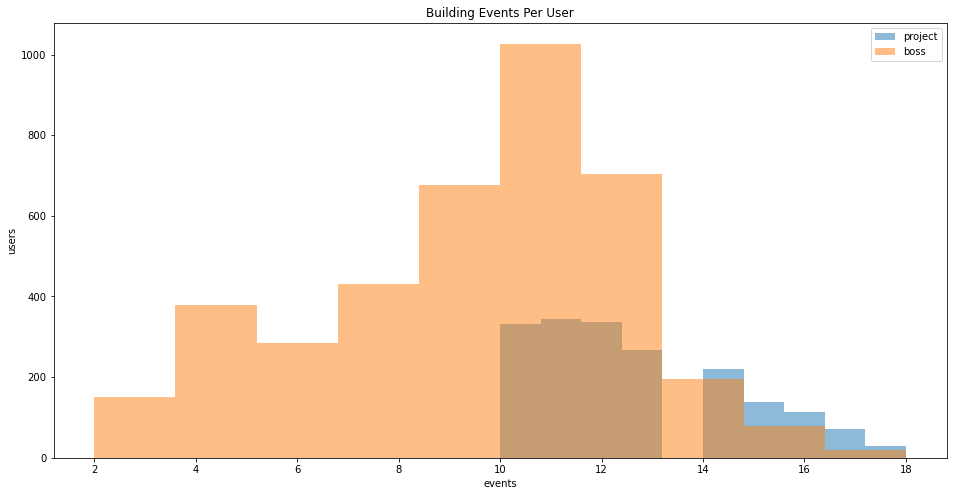

In [55]:
plt.figure(figsize=(16, 8))
plt.hist(data=buildings_per_user.loc[buildings_per_user.loc[:,'p_or_b'] == 'project'], x='event_datetime', bins=(10), alpha=0.5)
plt.hist(data=buildings_per_user.loc[buildings_per_user.loc[:,'p_or_b'] == 'boss'], x='event_datetime', bins=(10), alpha=0.5)
plt.title('Building Events Per User')
plt.ylabel('users')
plt.xlabel('events')
plt.legend(labels=['project', 'boss'])
plt.show()

We can see here that users are much more likely to complete more "building" events if they are in the "project" group. Both groups peak around (11). However, "boss" has a negative skew, while "project" has a positive skew. Users must find it more exciting to win by defeating the boss. However, it seems that they will be exposed to more adds if they take the "project" route.

Let's take a look at what the average "building" event per user and source, and display it on a bar chart with a line indicating the overall average.

In [56]:
building_events_per_user_and_source = buildings_per_user.groupby('source').agg({'event_datetime' : 'mean'})
building_events_per_user_and_source

,event_datetime
source,
facebook_ads,9.568173
google_play_ads,9.338529
instagram_new_adverts,9.496711
youtube_channel_network,9.280865


In [57]:
building_events_per_user = buildings_per_user['event_datetime'].mean()
print('Average "building" events per user: ', building_events_per_user)

Average "building" events per user:  9.412228942321876


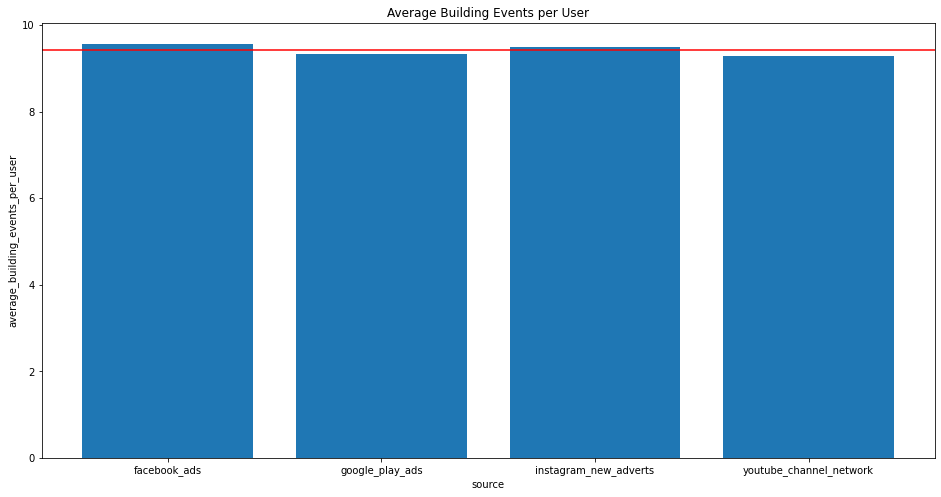

In [58]:
plt.figure(figsize=(16, 8))
plt.bar(building_events_per_user_and_source.index, building_events_per_user_and_source['event_datetime'])
plt.title('Average Building Events per User')
plt.ylabel('average_building_events_per_user')
plt.xlabel('source')
plt.axhline(y=building_events_per_user, color='r', linestyle='-')
plt.show()

The average user encountered around 9 "building" events. facebook_ads and instagram_new_adverts are above average, but all sources are near the overall average.

Let's move on to look at users per day.

### Users Per Day

Let's calculate the daily active users for each source using a pivot table and plot a histogram to see the distribution.

In [59]:
users_per_day = events.pivot_table(index='event_date', columns='source', values='user_id', aggfunc='nunique')
users_per_day

source,facebook_ads,google_play_ads,instagram_new_adverts,youtube_channel_network
event_date,,,,
2020-05-04,1182.0,2074.0,1449.0,1143.0
2020-05-05,1323.0,2289.0,1537.0,1220.0
2020-05-06,1385.0,2440.0,1669.0,1347.0
2020-05-07,1530.0,2609.0,1800.0,1429.0
2020-05-08,1578.0,2781.0,1960.0,1557.0
2020-05-09,1696.0,2953.0,2074.0,1654.0
2020-05-10,1855.0,3266.0,2298.0,1782.0
2020-05-11,1275.0,2161.0,1429.0,1117.0
2020-05-12,1149.0,2027.0,1455.0,1132.0


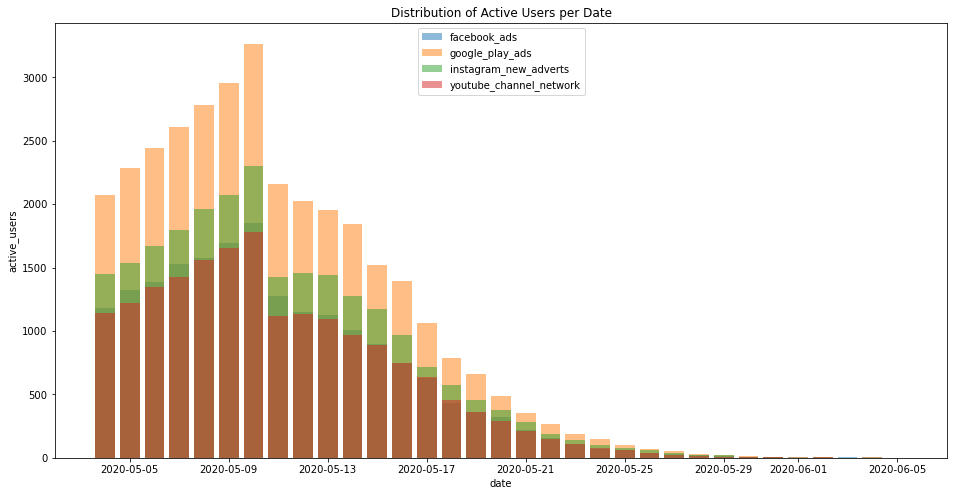

In [60]:
plt.figure(figsize=(16, 8))
plt.bar(users_per_day.index, users_per_day['facebook_ads'], alpha=0.5)
plt.bar(users_per_day.index, users_per_day['google_play_ads'], alpha=0.5)
plt.bar(users_per_day.index, users_per_day['instagram_new_adverts'], alpha=0.5)
plt.bar(users_per_day.index, users_per_day['youtube_channel_network'], alpha=0.5)
plt.title('Distribution of Active Users per Date')
plt.ylabel('active_users')
plt.xlabel('date')
plt.legend(labels=users_per_day.columns)
plt.show()

Daily active users peak on 2020-05-09 and drop sharply after that. This is because the ads ran until that date, and most users are not likely to stick around for very long. The users that do remain are likely to finish stage 1. This would account for the gradually reducing tail. Each source has a similar distribution.

### Events Per Day

Let's look at the average number of events per day using a histogram.

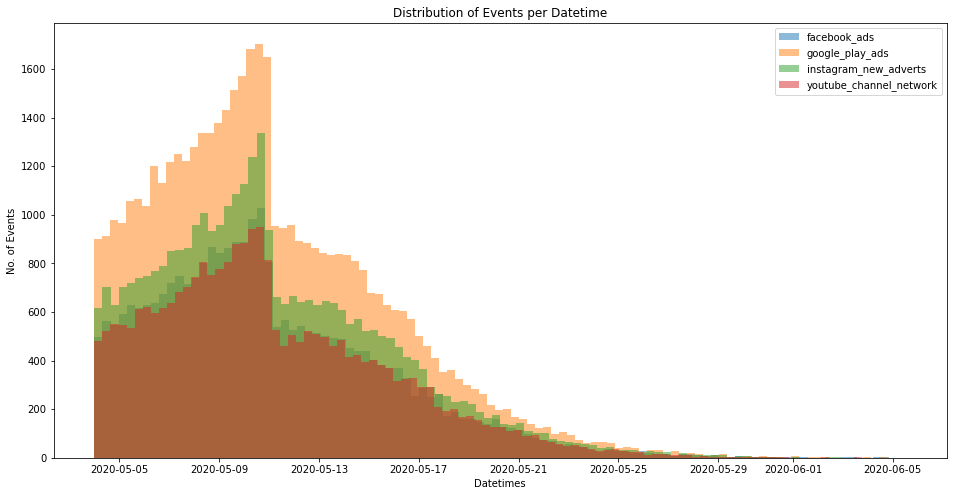

In [61]:
plt.figure(figsize=(16, 8))
plt.hist(data=events.loc[events.loc[:,'source'] == 'facebook_ads'], x='event_datetime', bins=(100), alpha=0.5)
plt.hist(data=events.loc[events.loc[:,'source'] == 'google_play_ads'], x='event_datetime', bins=(100), alpha=0.5)
plt.hist(data=events.loc[events.loc[:,'source'] == 'instagram_new_adverts'], x='event_datetime', bins=(100), alpha=0.5)
plt.hist(data=events.loc[events.loc[:,'source'] == 'youtube_channel_network'], x='event_datetime', bins=(100), alpha=0.5)
plt.title('Distribution of Events per Datetime')
plt.ylabel('No. of Events')
plt.xlabel('Datetimes')
plt.legend(labels=users_per_day.columns)
plt.show()

This histogram matches the users_per_day histogram, and the nature of the distribution can be explained similarly. Let's take a look at how many days users stick around. To do this, we will group by user_id and pull the max days_since_ad_date, including the course information as well. We will then plot a histogram.

In [62]:
max_days = events.groupby('user_id').agg({'days_since_ad_date' : 'max', 'source' : 'first', 'p_or_b' : 'first'})
max_days.head()

,days_since_ad_date,source,p_or_b
user_id,,,
0001f83c-c6ac-4621-b7f0-8a28b283ac30,14,facebook_ads,incomplete
00151b4f-ba38-44a8-a650-d7cf130a0105,12,google_play_ads,incomplete
001aaea6-3d14-43f1-8ca8-7f48820f17aa,9,youtube_channel_network,incomplete
001d39dc-366c-4021-9604-6a3b9ff01e25,7,instagram_new_adverts,boss
002f508f-67b6-479f-814b-b05f00d4e995,17,facebook_ads,incomplete


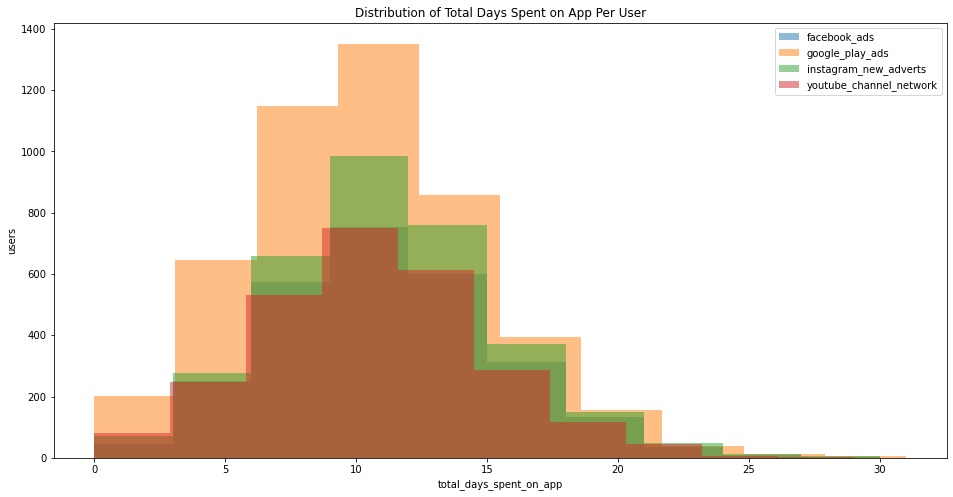

In [63]:
plt.figure(figsize=(16, 8))
plt.hist(data=max_days.loc[max_days.loc[:,'source'] == 'facebook_ads'], x='days_since_ad_date', bins=(10), alpha=0.5)
plt.hist(data=max_days.loc[max_days.loc[:,'source'] == 'google_play_ads'], x='days_since_ad_date', bins=(10), alpha=0.5)
plt.hist(data=max_days.loc[max_days.loc[:,'source'] == 'instagram_new_adverts'], x='days_since_ad_date', bins=(10), alpha=0.5)
plt.hist(data=max_days.loc[max_days.loc[:,'source'] == 'youtube_channel_network'], x='days_since_ad_date', bins=(10), alpha=0.5)
plt.title('Distribution of Total Days Spent on App Per User')
plt.ylabel('users')
plt.xlabel('total_days_spent_on_app')
plt.legend(labels=users_per_day.columns)
plt.show()

Most users spend about 10 days on the app. Distribution is skewed slightly left while the right side has a thinner tail. The most drastic drop off is after the 15th day.

Let's see what the distributions look like when comparing users who completed stage 1 to those who haven't.

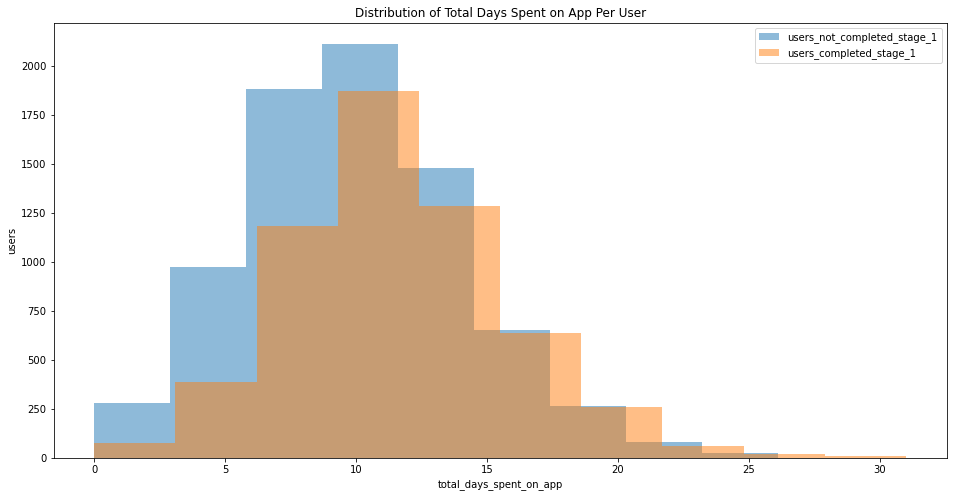

In [64]:
plt.figure(figsize=(16, 8))
plt.hist(data=max_days.loc[max_days.loc[:,'p_or_b'] == 'incomplete'], x='days_since_ad_date', bins=(10), alpha=0.5)
plt.hist(data=max_days.loc[max_days.loc[:,'p_or_b'] != 'incomplete'], x='days_since_ad_date', bins=(10), alpha=0.5)
plt.title('Distribution of Total Days Spent on App Per User')
plt.ylabel('users')
plt.xlabel('total_days_spent_on_app')
plt.legend(labels=['users_not_completed_stage_1', 'users_completed_stage_1'])
plt.show()

As was to be expected, users who completed stage 1 spent slightly more days on the app than users who did not. Finally, let's break it down by "project" vs. "boss" groups.

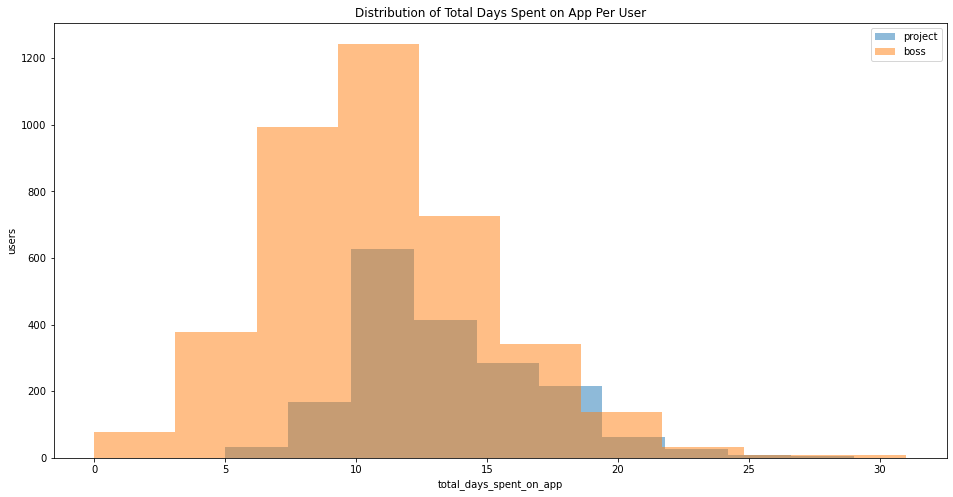

In [65]:
plt.figure(figsize=(16, 8))
plt.hist(data=max_days.loc[max_days.loc[:,'p_or_b'] == 'project'], x='days_since_ad_date', bins=(10), alpha=0.5)
plt.hist(data=max_days.loc[max_days.loc[:,'p_or_b'] == 'boss'], x='days_since_ad_date', bins=(10), alpha=0.5)
plt.title('Distribution of Total Days Spent on App Per User')
plt.ylabel('users')
plt.xlabel('total_days_spent_on_app')
plt.legend(labels=['project', 'boss'])
plt.show()

"boss" users have a negative skew, while "project" users have a positive skew. This mean that "project" users spend more days on the app in addition to completing more events.

### EDA Summary

We have uncovered the following thus far:

The users from our dataset represent a sample group who responded to a week’s long worth of advertisements. Across that week and for all sources, costs for new users we creased by about half every day. It appears that the costs were per click. We were unable to conclude why the new users were halted every day of the add run, but suggested it may be due to the initial exposure on day one reaching the biggest audience and gaining the most clicks, while the following days reached less and less of a new audience.

We calculated the cost per user for all sources and discovered that facebook_ads and instagram_new_adverts were more expensive than average while google_play_ads and youtube_channel_network were less expensive than average.

The events dataset covers a period of (33) days and includes no information after stage 1 of the app game. 43% of users completed stage 1 of the app game during these (33) days. 39% of the users completed stage 1 via defeating the boss of the game and 14% completed stage 1 via completing the project in the game (the satellite orbital assembly). The percentages had marginal difference across sources. However, youtube_channel_network had the best performance for stage 1 completion and facebook_ads had the worst performance. (Let’s remember that youtube_channel_network is the least expensive ad source and facebook_ads is the most expensive.) Users who completed stage 1 of the game completed more events than users who did not.

There were a couple outliers for “p” and “b” groups which we removed for a more accurate comparison later on. Group “p” must complete at least (10) building events to complete the project, while “b” group completed a minimum of (2) building events, and their histogram peaked at (10). This leads us to conclude that “p” group will have much more exposure to the ads on the app, which we expect to be arranged near the building menu in the game.

Users and events per day peaked during the final day of source advertisements and dropped sharply after that. Most users spent (10) days on the app. Users who completed stage 1 spent more days on the app than users who did not.

Let's look at the relationship between object types built between "p" and "b" groups.

## Relationship Between object_type and p_or_b Groups

As can be seen above, all users who completed stage 1 also completed the project in addition to the various buildings they constructed. Let's take a look at how the various building types are distributed as well. We will remove the satellite_orbital_assembly from the object types because it is redundant information.

In [66]:
object_types = events.pivot_table(index='object_type', columns='p_or_b', values='event_datetime', aggfunc='count')
object_types = object_types.drop('satellite_orbital_assembly')
object_types

p_or_b,boss,incomplete,project
object_type,,,
assembly_shop,16279.0,29080.0,9015.0
research_center,3745.0,6685.0,3646.0
spaceport,17104.0,31405.0,10652.0


To get a better idea of the relationship between the various object types and our p_or_b classifications, let's calculate total number of buildings for p_or_b group and add columns showing the proportions of each object_type.

In [67]:
boss_total_buildings = len(events.loc[(events.loc[:,'p_or_b'] == 'boss') &\
                                      (events.loc[:,'event'] == 'building')])
incomplete_total_buildings = len(events.loc[(events.loc[:,'p_or_b'] == 'incomplete') &\
                                            (events.loc[:,'event'] == 'building')])
project_total_buildings = len(events.loc[(events.loc[:,'p_or_b'] == 'project') &\
                                         (events.loc[:,'event'] == 'building')])

In [68]:
object_types['boss_proportions'] = object_types['boss'] / boss_total_buildings
object_types['incomplete_proportions'] = object_types['incomplete'] / incomplete_total_buildings
object_types['project_proportions'] = object_types['project'] / project_total_buildings
object_types

p_or_b,boss,incomplete,project,boss_proportions,incomplete_proportions,project_proportions
object_type,,,,,,
assembly_shop,16279.0,29080.0,9015.0,0.438456,0.432931,0.386694
research_center,3745.0,6685.0,3646.0,0.100867,0.099524,0.156393
spaceport,17104.0,31405.0,10652.0,0.460677,0.467545,0.456912


Let's analyze the results. "boss" group resembles "incomplete" group closely. "project" group invests more into research centers and less into assembly shops. This must mean that research centers are a key factor in winning the game through the project route.

## Test Statistical Hypotheses

We now test our hypotheses on the "p" and "b" groups. The hypothesis is as follows:

"p" users take the same amount of days as "b" users to complete stage 1.

We will also test this hypothesis across all sources to confirm that the result is consistent for each source.

### Amount of Days Before Completion between "p" and "b" Groups

Let's count the max number of days for each group.We will also include "source" information for each user for when we test the same hypothesis across all sources later.

In [69]:
#Count max number of days for "p" users
max_days_p = events.loc[events.loc[:,'p_or_b'] == 'project'].groupby('user_id')\
.agg({'days_since_ad_date' : 'max', 'source' : 'first'})

#Count max number of days for "p" users
max_days_b = events.loc[events.loc[:,'p_or_b'] == 'boss'].groupby('user_id')\
.agg({'days_since_ad_date' : 'max', 'source' : 'first'})

Now we are ready to test our first hypothesis:

Null hypothesis: There is NO statistically significant difference between the amount of days it takes for "p" users and "b" users to complete stage 1 of the gaming app.

Alternative hypothesis: There IS a statistically significance difference between the amount of days it takes for "p" users and "b" users to complete stage 1 of the gaming app.

We will choose a statistical significance level of 0.05.

In [70]:
#critical statistical significance level
alpha = 0.05

# if the p-value is greater than alpha, we reject the hypothesis
results = st.ttest_ind(max_days_p['days_since_ad_date'], max_days_b['days_since_ad_date'])

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis") 

p-value:  7.264168478715991e-96
We reject the null hypothesis


From this we can conclude that there IS a statistically significant difference in the number of days it takes for each group to complete the first stage. Let's take a look at the averages and how the number of days are distributed between the groups.

Average days spent for "p" users: 13.396542409508374
Average days spent for "b" users: 11.05420466058764


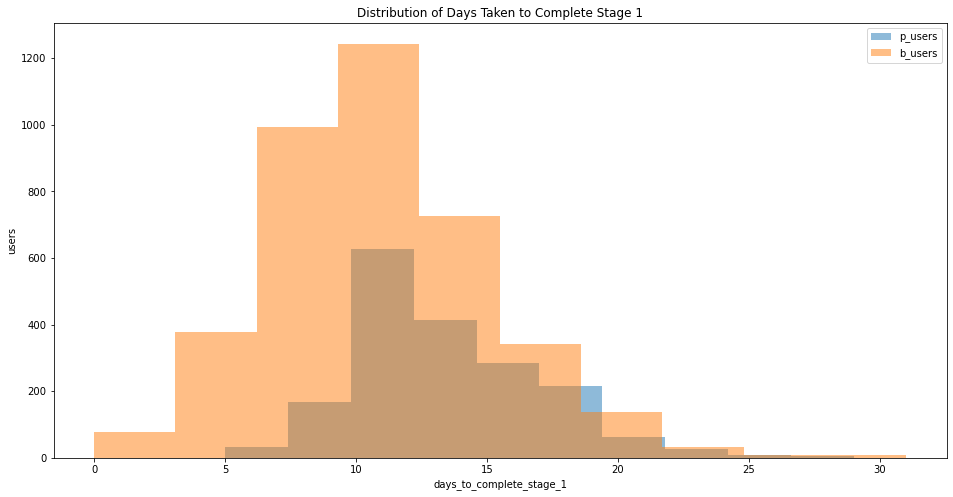

In [71]:
print('Average days spent for "p" users:', max_days_p['days_since_ad_date'].mean())
print('Average days spent for "b" users:', max_days_b['days_since_ad_date'].mean())

plt.figure(figsize=(16, 8))
plt.hist(data=max_days_p, x='days_since_ad_date', bins=(10), alpha=0.5)
plt.hist(data=max_days_b, x='days_since_ad_date', bins=(10), alpha=0.5)
plt.title('Distribution of Days Taken to Complete Stage 1')
plt.ylabel('users')
plt.xlabel('days_to_complete_stage_1')
plt.legend(labels=['p_users', 'b_users'])
plt.show()

"p" users took more days than "b" users. "p" users were unable to complete their satellite_orbital_assembly project until day 5 at the soonest. Some "b" users, on the other hand, were able to defeat the boss right away. This may be due to the fact that "b" users far outweigh "p" users, and so there is more representation for "b" users. Either way, "b" users have a negative skew while "p" users are skewed positive. Both groups peak around the 10th day.

### Testing Across Each Source

Now, let's create a for loop based on each source. We will perform the same test as we did above with the same hypothesis. However, we will test for times for each source.

In [72]:
for source in events['source'].unique():
    results = st.ttest_ind(max_days_p.loc[max_days_p.loc[:,'source'] == source]['days_since_ad_date'],
                           max_days_b.loc[max_days_b.loc[:,'source'] == source]['days_since_ad_date'])

    print(source)
    print('Average days spent for "p" users:', max_days_p.loc[max_days_p.loc[:,'source'] == source]
          ['days_since_ad_date'].mean())
    print('Average days spent for "b" users:', max_days_b.loc[max_days_b.loc[:,'source'] == source]
          ['days_since_ad_date'].mean())

    print('p-value: ', results.pvalue)

    if results.pvalue < alpha:
        print("We reject the null hypothesis")
    else:
        print("We can't reject the null hypothesis")
    print()

youtube_channel_network
Average days spent for "p" users: 13.505347593582888
Average days spent for "b" users: 11.074358974358974
p-value:  2.0393923813323849e-22
We reject the null hypothesis

facebook_ads
Average days spent for "p" users: 13.351421188630491
Average days spent for "b" users: 10.982849604221636
p-value:  3.0252696479640318e-21
We reject the null hypothesis

instagram_new_adverts
Average days spent for "p" users: 13.465116279069768
Average days spent for "b" users: 11.06868686868687
p-value:  1.888187150343146e-27
We reject the null hypothesis

google_play_ads
Average days spent for "p" users: 13.306320907617504
Average days spent for "b" users: 11.07112676056338
p-value:  3.715766557263387e-30
We reject the null hypothesis



We can see here that the hypothesis is rejected for all sources. That means that there is a statistically significant difference in the number of days between "p" and "b" groups for all sources. We can also see from the averages here, that facebook_ads is the lowest perform in number of days despite it being the most expensive ad source.

### Summary

We have rejected our null hypothesis in all cases, and revealed "p" and "b" groups to be distinct in the number of days taken to complete stage 1.

## Performance Per Source

We have established that a great target variable is users who have completed stage 1. Another great target variable is "p" group users. Now, we will display the proportions of users for each source that completed the game and the proportion that are part of "p" group. We will compare them next to the cost per user for each source, and calculate a performance rate by which to rank and evaluate the various sources. To do this, let's modify our previous costs_per_source table to include the proportion of users who complete the first stage of the game. We will show the results along side the averages. Let's start by adding the completed users proportions to our costs_per_source table.

In [73]:
costs_per_source['proportion_completed'] = stage_1_completed_proportions['stage_1_completed']

costs_per_source

,cost,users,cost_per_user,proportion_completed
source,,,,
facebook_ads,2140.904643,2726,0.785365,0.421864
google_play_ads,2233.111449,4817,0.463590,0.423915
instagram_new_adverts,2161.441691,3347,0.645785,0.438004
youtube_channel_network,1068.119204,2686,0.397662,0.431497


We now have the proportions of users who have completed the first stage per source. Let's calculate the performance rate based on these proportions. 

In [74]:
#Calculate column showing source "performance rate"
costs_per_source['completed_performance_rate'] = costs_per_source['proportion_completed']\
/ costs_per_source['cost_per_user']
costs_per_source

,cost,users,cost_per_user,proportion_completed,completed_performance_rate
source,,,,,
facebook_ads,2140.904643,2726,0.785365,0.421864,0.537156
google_play_ads,2233.111449,4817,0.463590,0.423915,0.914419
instagram_new_adverts,2161.441691,3347,0.645785,0.438004,0.678251
youtube_channel_network,1068.119204,2686,0.397662,0.431497,1.085085


Source: youtube_channel_network is the stand out performance, scoring twice as much as the weakest source, facebook_ads.

Now, let's add a column for the proportion of "p" users. To do this, we will create create a new Boolean column in our "events" dataset indicating whether each user is in group "p" or not. We will then convert the column from True and False to 1 and 0 using .multiply() from numpy. We will convert the column to integer as well.

In [75]:
events['p_users'] = np.where(events['p_or_b'] == 'project', True, False)
events['p_users'] = np.multiply(events['p_users'], 1)
events['p_users'] = events['p_users'].astype(int)
events

,event_datetime,event,object_type,user_id,ad_date,source,event_date,days_since_ad_date,stage_1_completed,p_or_b,p_users
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-04,0,0,incomplete,0
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-05,1,0,incomplete,0
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-05,1,0,incomplete,0
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-05,1,0,incomplete,0
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,youtube_channel_network,2020-05-06,2,0,incomplete,0
...,...,...,...,...,...,...,...,...,...,...,...
135634,2020-05-13 23:56:39,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,2020-05-10,facebook_ads,2020-05-13,3,0,incomplete,0
135635,2020-05-18 00:23:28,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,2020-05-10,facebook_ads,2020-05-18,8,0,incomplete,0
135636,2020-05-10 23:59:52,building,assembly_shop,bdc53e19-462a-4dc3-8b55-b4a34278af6a,2020-05-10,youtube_channel_network,2020-05-10,0,0,incomplete,0
135637,2020-05-13 08:11:19,building,spaceport,bdc53e19-462a-4dc3-8b55-b4a34278af6a,2020-05-10,youtube_channel_network,2020-05-13,3,0,incomplete,0


We now have a column showing a 1 for whether users are "p" group. Let's group each user, averaging the p_users to get a proportion by source.

In [76]:
p_proportions_per_source = events.groupby('user_id').first().groupby('source').agg({'p_users' : 'mean'})
p_proportions_per_source

,p_users
source,
facebook_ads,0.142227
google_play_ads,0.128221
instagram_new_adverts,0.141447
youtube_channel_network,0.139500


Now, let's add the results to our costs_per_source table.

In [77]:
costs_per_source['proportion_p'] = p_proportions_per_source['p_users']
costs_per_source

,cost,users,cost_per_user,proportion_completed,completed_performance_rate,proportion_p
source,,,,,,
facebook_ads,2140.904643,2726,0.785365,0.421864,0.537156,0.142227
google_play_ads,2233.111449,4817,0.463590,0.423915,0.914419,0.128221
instagram_new_adverts,2161.441691,3347,0.645785,0.438004,0.678251,0.141447
youtube_channel_network,1068.119204,2686,0.397662,0.431497,1.085085,0.139500


We now have the proportions of users who have completed the first stage per source. Let's calculate the performance rate based on these proportions.

In [78]:
#Calculate column showing source "performance rate"
costs_per_source['p_performance_rate'] = costs_per_source['proportion_p']\
/ costs_per_source['cost_per_user']
costs_per_source

,cost,users,cost_per_user,proportion_completed,completed_performance_rate,proportion_p,p_performance_rate
source,,,,,,,
facebook_ads,2140.904643,2726,0.785365,0.421864,0.537156,0.142227,0.181097
google_play_ads,2233.111449,4817,0.463590,0.423915,0.914419,0.128221,0.276583
instagram_new_adverts,2161.441691,3347,0.645785,0.438004,0.678251,0.141447,0.219032
youtube_channel_network,1068.119204,2686,0.397662,0.431497,1.085085,0.139500,0.350801


The performance rate for "p" group shows a similar ranking of sources as the performance rate based on completed users.

Let's calculate the overall totals, proportion rates and performance rates and add the row to our table.

In [79]:
all_cost = costs_per_source['cost'].sum()
all_users = costs_per_source['users'].sum()
all_cost_per_user = all_cost / all_users
all_proportion_completed = events.groupby('user_id')['stage_1_completed'].mean().mean()
all_completed_performance_rate = all_proportion_completed / all_cost_per_user
all_proportion_p = events.groupby('user_id')['p_users'].mean().mean()
all_p_performance_rate =  all_proportion_p / all_cost_per_user

In [80]:
new_row_for_all_sources = {'source': 'all_sources', 'cost': all_cost, 'users': all_users,
                           'cost_per_user': all_cost_per_user, 'proportion_completed': all_proportion_completed,\
                           'completed_performance_rate': all_completed_performance_rate,\
                           'proportion_p': all_proportion_p, 'p_performance_rate': all_p_performance_rate}

final_performance_table = costs_per_source.reset_index()
final_performance_table = final_performance_table.append(new_row_for_all_sources, ignore_index=True)

final_performance_table

,source,cost,users,cost_per_user,proportion_completed,completed_performance_rate,proportion_p,p_performance_rate
0,facebook_ads,2140.904643,2726,0.785365,0.421864,0.537156,0.142227,0.181097
1,google_play_ads,2233.111449,4817,0.463590,0.423915,0.914419,0.128221,0.276583
2,instagram_new_adverts,2161.441691,3347,0.645785,0.438004,0.678251,0.141447,0.219032
3,youtube_channel_network,1068.119204,2686,0.397662,0.431497,1.085085,0.139500,0.350801
4,all_sources,7603.576987,13576,0.560075,0.427718,0.763680,0.136525,0.243761


Now we have a row showing the data for all sources. Let's plot two bar charts to compare the performance rate for each source to the overall performance rate. We will do this for performance rates based on both completed users as well as "p" group.

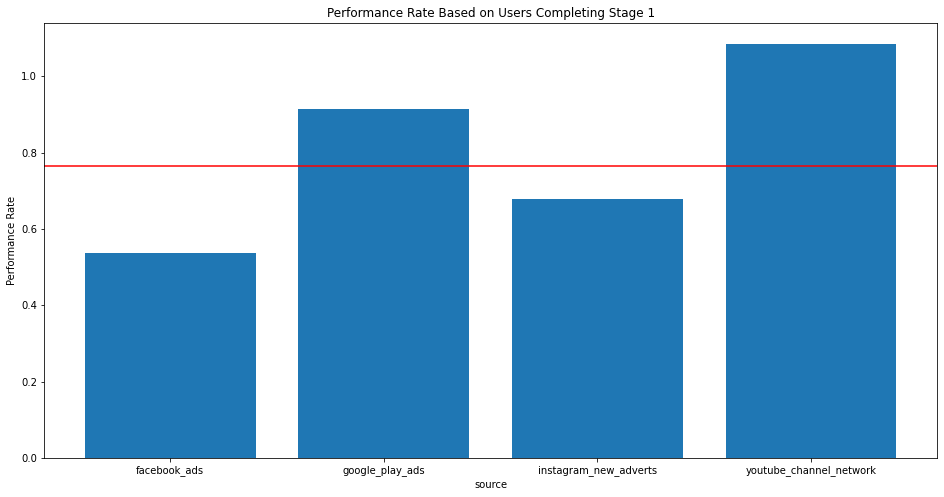

In [81]:
plt.figure(figsize=(16, 8))
plt.bar(['facebook_ads', 'google_play_ads', 'instagram_new_adverts', 'youtube_channel_network'],\
        costs_per_source['completed_performance_rate'])
plt.title('Performance Rate Based on Users Completing Stage 1')
plt.ylabel('Performance Rate')
plt.xlabel('source')
plt.axhline(y=all_completed_performance_rate, color='r', linestyle='-')
plt.show()

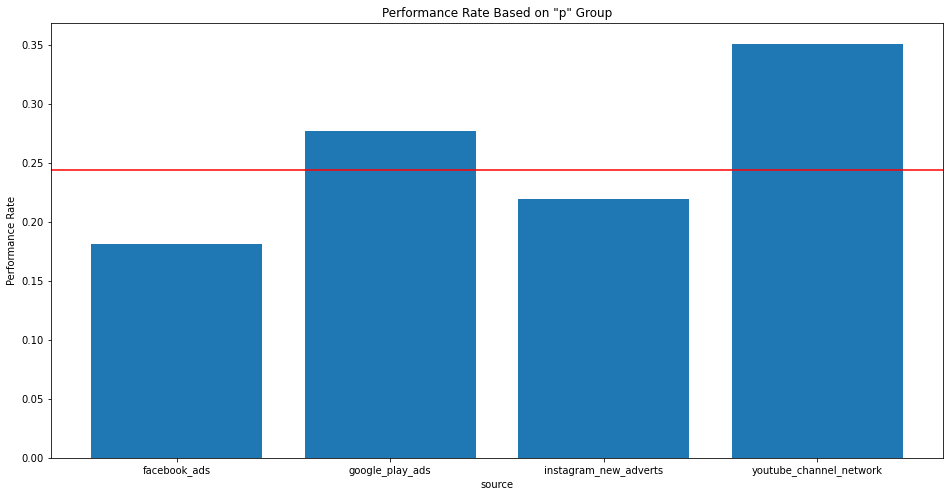

In [82]:
plt.figure(figsize=(16, 8))
plt.bar(['facebook_ads', 'google_play_ads', 'instagram_new_adverts', 'youtube_channel_network'],\
        costs_per_source['p_performance_rate'])
plt.title('Performance Rate Based on "p" Group')
plt.ylabel('Performance Rate')
plt.xlabel('source')
plt.axhline(y=all_p_performance_rate, color='r', linestyle='-')
plt.show()

We now have two performance rates determined using to target variables (completed users and "p" group) 

## Conclusions and Reccomendations

We investigated the "costs" to find that new users declined by a consistent rate each day of the week-long ad run. Cost per user showed a wide variance per source, facebook_ads being the most expensive and youtube_channel_network being the cheapest.

42% of users completed the first stage of the game. A third of these users completed stage 1 via the "project" route. The rest completed the first stage by defeating the boss.

Regarding target values, we have concluded the following:
- The more users encounter the building events, the more likely they are to interact with in-game advertisements.
- Users who complete the first stage of the game are more likely to have encountered the building events than users who did not complete the first stage.
- Users who complete the first stage of the game are more likely to have spent more days on the app than the users who did not complete the first stage.
- Users who complete the first stage are more likely to continue playing the game, encountering more building events in the future and spending more days on the app in the future.
- As such, stage_1_completed is a key target variable.
- Among users who have completed the first stage of the app, there are two categories: "p" (those who complete the game through completing the satellite_orbital_assembly project) and "b" (those who complete the first stage by defeating the boss)
- Among the groups "p" and "b", "p" group is the better performer in terms of the number of building events they encounter and the number of days they spend on the app.
- "p" group is an even more desirable target value than the group that finished the first stage.

Users remain more or less consistent regardless of source. However, there is a slight variance. We calculated costs per user and proportions of users who participated in the target groups. We used this information to come up with two performance rates, one based on user who completed the first stage, the other based on users who were part of "p" group.

I recommend that decisions on advertising be based on the performance rates presented in the bar charts above, with youtube_channel_network receiving the most funding and facebook_ads receiving the least.

Additionally, I recommend that the game be adjusted to encourage more users to pursue the "project" route to completing the first round. This will facilitate more add interaction and more  days spent on the app.

Presentation link: https://drive.google.com/file/d/1Rq9MQWN0T-fsgCCdix6FYQiqe957mY8B/view?usp=sharing

Tabluea Dashboard Link: https://public.tableau.com/authoring/GamesMonetizationModelDashboard/Dashboard1#1